In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, ConcatDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import matplotlib.pyplot as plt
import ast
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
import copy

In [2]:
class F1RaceDataset(Dataset):
    def __init__(self, features, targets, numerical_cols, categorical_cols, scaler=None, pitstop_scaler=None):
        """
        Args:
            features (pd.DataFrame): Feature data
            targets (pd.DataFrame): Target data
            numerical_cols (list): Names of numerical columns
            categorical_cols (list): Names of categorical columns
            scaler (StandardScaler, optional): Pre-fitted scaler for numerical features
            pitstop_scaler (StandardScaler, optional): Pre-fitted scaler for pitstop laps
        """
        self.features = features
        self.targets = targets
        self.numerical_cols = numerical_cols
        self.categorical_cols = categorical_cols
        
        # Constants for padding
        self.MAX_PITSTOPS = 7
        self.MAX_TYRES = 8
        self.NUM_TYRE_CLASSES = 8
        
        # Scale numerical features using provided or new scaler
        if scaler is None:
            self.scaler = StandardScaler()
            scaled_features = self.scaler.fit_transform(self.features[numerical_cols])
        else:
            self.scaler = scaler
            scaled_features = self.scaler.transform(self.features[numerical_cols])
        
        # Process list features
        pitstop_laps, pitstop_masks = self._process_pitstop_laps()
        
        # Scale pit stop laps using provided or new scaler
        if pitstop_scaler is None:
            self.pitstop_scaler = StandardScaler()
            valid_laps = pitstop_laps[pitstop_masks]
            if len(valid_laps) > 0:
                valid_laps_reshaped = valid_laps.reshape(-1, 1)
                self.pitstop_scaler.fit(valid_laps_reshaped)
                pitstop_laps_reshaped = pitstop_laps.reshape(-1, 1)
                scaled_pitstop_laps = self.pitstop_scaler.transform(pitstop_laps_reshaped)
                pitstop_laps = scaled_pitstop_laps.reshape(pitstop_laps.shape)
        else:
            self.pitstop_scaler = pitstop_scaler
            pitstop_laps_reshaped = pitstop_laps.reshape(-1, 1)
            scaled_pitstop_laps = self.pitstop_scaler.transform(pitstop_laps_reshaped)
            pitstop_laps = scaled_pitstop_laps.reshape(pitstop_laps.shape)
            
        tyre_compounds, tyre_masks = self._process_tyre_compounds()
        
        # Convert to tensors
        self.numerical_features = torch.FloatTensor(scaled_features)
        self.categorical_features = torch.LongTensor(self.features[categorical_cols].values)
        self.pitstop_laps = torch.FloatTensor(pitstop_laps)  # Changed to FloatTensor since we're scaling
        self.pitstop_masks = torch.BoolTensor(pitstop_masks)
        self.tyre_compounds = torch.LongTensor(tyre_compounds)
        self.tyre_masks = torch.BoolTensor(tyre_masks)
        self.targets = torch.FloatTensor(self.targets.values)
    
    def _process_pitstop_laps(self):
        """Process PitStopLaps lists with padding"""
        pit_lists = self.features['PitStopLaps'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
        
        padded_data = np.zeros((len(pit_lists), self.MAX_PITSTOPS), dtype=np.float64)  # Changed to float64
        masks = np.zeros((len(pit_lists), self.MAX_PITSTOPS), dtype=bool)
        
        for i, pit_list in enumerate(pit_lists):
            if isinstance(pit_list, list) and len(pit_list) > 0:
                length = min(len(pit_list), self.MAX_PITSTOPS)
                padded_data[i, :length] = pit_list[:length]
                masks[i, :length] = True
        
        return padded_data, masks
    
    def _process_tyre_compounds(self):
        """Process TyreCompounds_encoded lists with padding"""
        tyre_lists = self.features['TyreCompounds_encoded'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
        
        padded_data = np.zeros((len(tyre_lists), self.MAX_TYRES), dtype=np.int64)
        masks = np.zeros((len(tyre_lists), self.MAX_TYRES), dtype=bool)
        
        for i, tyre_list in enumerate(tyre_lists):
            if isinstance(tyre_list, list) and len(tyre_list) > 0:
                length = min(len(tyre_list), self.MAX_TYRES)
                padded_data[i, :length] = tyre_list[:length]
                masks[i, :length] = True
        
        return padded_data, masks
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return {
            'numerical_features': self.numerical_features[idx],
            'categorical_features': self.categorical_features[idx],
            'pitstop_laps': self.pitstop_laps[idx],
            'pitstop_masks': self.pitstop_masks[idx],
            'tyre_compounds': self.tyre_compounds[idx],
            'tyre_masks': self.tyre_masks[idx],
            'target': self.targets[idx]
        }

In [3]:
class MixupF1Dataset(Dataset):
    def __init__(self, base_dataset, alpha=0.2):
        self.base_dataset = base_dataset
        self.alpha = alpha
        
    def __len__(self):
        return len(self.base_dataset)
        
    def __getitem__(self, idx):
        # Get first sample
        sample1 = self.base_dataset[idx]
        
        # Randomly select second sample
        idx2 = random.randint(0, len(self.base_dataset) - 1)
        sample2 = self.base_dataset[idx2]
        
        # Generate mixup weight from beta distribution
        if self.alpha > 0:
            lam = np.random.beta(self.alpha, self.alpha)
        else:
            lam = 1
            
        # Interpolate numerical features
        mixed_numerical = lam * sample1['numerical_features'] + (1 - lam) * sample2['numerical_features']
        
        # Keep categorical features from the dominant sample
        if lam > 0.5:
            dominant_sample = sample1
        else:
            dominant_sample = sample2
            
        return {
            'numerical_features': mixed_numerical,
            'categorical_features': dominant_sample['categorical_features'],
            'pitstop_laps': dominant_sample['pitstop_laps'],
            'pitstop_masks': dominant_sample['pitstop_masks'],
            'tyre_compounds': dominant_sample['tyre_compounds'],
            'tyre_masks': dominant_sample['tyre_masks'],
            'target': lam * sample1['target'] + (1 - lam) * sample2['target']
        }

def create_dataloaders(batch_size=64, train_size=0.6, val_size=0.2, 
                      random_state=42, use_mixup=False, mixup_alpha=0.2, use_stratified=True):
    """
    Create train, validation, and test dataloaders with stratified sampling
    """
    features = pd.read_csv('data/processed_features.csv')
    targets = pd.read_csv('data/processed_targets.csv')
    
    numerical_cols = ['Round', 'GridPosition', 'NumParticipants',
                 'AirTemp', 'Humidity', 'Pressure', 'TrackTemp',
                 'WindDirection', 'WindSpeed', 'Q1Time', 'Laps']

    categorical_cols = ['Season_encoded', 'Circuit_encoded', 'Team_encoded', 
                    'Driver_encoded', 'NumPitStops']
    
    # Create position change bins for stratification
    def create_position_bins(pos_changes):
        bins = [-float('inf'), -10, -5, -2, -1, 0, 1, 2, 5, 10, float('inf')]
        return pd.cut(pos_changes, bins=bins, labels=range(len(bins)-1))
    
    # Stratify based on binned position changes
    position_bins = create_position_bins(targets['ClassificationResult'])
    
    # First split: train and temp
    train_features, temp_features, train_targets, temp_targets = train_test_split(
        features,
        targets['ClassificationResult'],
        train_size=train_size,
        random_state=random_state,
        stratify=position_bins if use_stratified else None
    )
    
    # Second split: divide temp into val and test
    val_features, test_features, val_targets, test_targets = train_test_split(
        temp_features,
        temp_targets,
        train_size=val_size/(1-train_size),
        random_state=random_state,
        stratify=create_position_bins(temp_targets) if use_stratified else None
    )

    # Create and fit scalers on training data
    feature_scaler = StandardScaler()
    feature_scaler.fit(train_features[numerical_cols])
    
    # Create and fit pitstop scaler
    pit_lists = train_features['PitStopLaps'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    padded_data = np.zeros((len(pit_lists), 7), dtype=np.float64)
    masks = np.zeros((len(pit_lists), 7), dtype=bool)
    
    for i, pit_list in enumerate(pit_lists):
        if isinstance(pit_list, list) and len(pit_list) > 0:
            length = min(len(pit_list), 7)
            padded_data[i, :length] = pit_list[:length]
            masks[i, :length] = True
    
    valid_laps = padded_data[masks]
    pitstop_scaler = StandardScaler()
    if len(valid_laps) > 0:
        pitstop_scaler.fit(valid_laps.reshape(-1, 1))

    # Create base datasets
    train_dataset = F1RaceDataset(
        train_features,
        train_targets,
        numerical_cols,
        categorical_cols,
        scaler=feature_scaler,
        pitstop_scaler=pitstop_scaler
    )
    
    val_dataset = F1RaceDataset(
        val_features,
        val_targets,
        numerical_cols,
        categorical_cols,
        scaler=feature_scaler,
        pitstop_scaler=pitstop_scaler
    )
    
    test_dataset = F1RaceDataset(
        test_features,
        test_targets,
        numerical_cols,
        categorical_cols,
        scaler=feature_scaler,
        pitstop_scaler=pitstop_scaler
    )
    
    # Initialize the final training dataset
    final_train_dataset = train_dataset
    combined_targets = train_targets.values
    
    # Create weighted sampler for training data if using stratified sampling
    train_sampler = None
    if use_stratified:
        # Calculate class weights using combined targets
        train_bins = create_position_bins(pd.Series(combined_targets))
        class_counts = np.bincount(train_bins)
        class_weights = 1.0 / class_counts
        sample_weights = class_weights[train_bins]
        sample_weights = sample_weights / sample_weights.sum()
        
        train_sampler = WeightedRandomSampler(
            weights=torch.DoubleTensor(sample_weights),
            num_samples=len(combined_targets),
            replacement=True
        )
    
    # Apply mixup if required
    if use_mixup:
        final_train_dataset = MixupF1Dataset(final_train_dataset, alpha=mixup_alpha)
    
    # Create final dataloaders
    train_loader = DataLoader(
        final_train_dataset,
        batch_size=batch_size,
        sampler=train_sampler if use_stratified and not use_mixup else None,
        shuffle=(not use_stratified) and (train_sampler is None)
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False
    )
    
    feature_dims = {
        'numerical_dim': len(numerical_cols),
        'categorical_dims': {
            'Season': len(features['Season_encoded'].unique()),
            'Circuit': len(features['Circuit_encoded'].unique()),
            'Team': len(features['Team_encoded'].unique()),
            'Driver': len(features['Driver_encoded'].unique()),
            'NumPitStops': 8,  # 0-7 possible pitstops
        },
        'embedding_dim': 32,
        'max_pitstops': 7,
        'max_tyres': 8,
        'num_tyre_classes': 8
    }
    
    return train_loader, val_loader, test_loader, feature_dims

In [4]:
# Create samble data loaders for printing to console
train_loader, val_loader, test_loader, feature_dims = create_dataloaders(
    batch_size=4
)

print("\nFeature dimensions:", feature_dims)
# Print number of samples in each loader
print("\nNumber of samples in each loader:")
print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")


print("\nFeature dimensions:", feature_dims)
# Get a batch from training data
print("\nExample batch from training data:")
for batch in train_loader:
    print("\nBatch shapes:")
    print("Numerical features shape:", batch['numerical_features'].shape)
    print("Categorical features shape:", batch['categorical_features'].shape)
    print("PitStop laps shape:", batch['pitstop_laps'].shape)
    print("PitStop masks shape:", batch['pitstop_masks'].shape)
    print("Tyre compounds shape:", batch['tyre_compounds'].shape)
    print("Tyre masks shape:", batch['tyre_masks'].shape)
    print("Target shape:", batch['target'].shape)
    
    # Print first sample details
    print("\n=== First Sample Details ===")
    
    print("\nNumerical features:")
    numerical_cols = ['Round', 'GridPosition', 'NumParticipants', 'NumPitStops',
                     'AirTemp', 'Humidity', 'Pressure', 'TrackTemp',
                     'WindDirection', 'WindSpeed', 'Q1Time', 'Laps']
    numerical_sample = batch['numerical_features'][0].cpu().numpy()
    for col, val in zip(numerical_cols, numerical_sample):
        print(f"{col}: {val:.4f}")
    
    print("\nCategorical features:")
    categorical_cols = ['Season_encoded', 'Circuit_encoded', 'Team_encoded', 
                   'Driver_encoded', 'NumPitStops']
    categorical_sample = batch['categorical_features'][0].cpu().numpy()
    for col, val in zip(categorical_cols, categorical_sample):
        print(f"{col}: {int(val)}")
    
    print("\nPitStop laps (with mask):")
    pitstop_laps = batch['pitstop_laps'][0].cpu().numpy()
    pitstop_masks = batch['pitstop_masks'][0].cpu().numpy()
    for i, (lap, mask) in enumerate(zip(pitstop_laps, pitstop_masks)):
        if mask:
            print(f"PitStop {i + 1}: Lap {lap}")
        else:
            print(f"PitStop {i + 1}: Padded (mask=False)")
    
    print("\nTyre compounds (with mask):")
    tyre_compounds = batch['tyre_compounds'][0].cpu().numpy()
    tyre_masks = batch['tyre_masks'][0].cpu().numpy()
    for i, (compound, mask) in enumerate(zip(tyre_compounds, tyre_masks)):
        if mask:
            print(f"Tyre {i + 1}: Compound {compound}")
        else:
            print(f"Tyre {i + 1}: Padded (mask=False)")
    
    print("\nTarget:", batch['target'][0].item())
    
    break  # Just print first batch


Feature dimensions: {'numerical_dim': 11, 'categorical_dims': {'Season': 7, 'Circuit': 34, 'Team': 18, 'Driver': 40, 'NumPitStops': 8}, 'embedding_dim': 32, 'max_pitstops': 7, 'max_tyres': 8, 'num_tyre_classes': 8}

Number of samples in each loader:
Training samples: 1437
Validation samples: 479
Test samples: 480

Feature dimensions: {'numerical_dim': 11, 'categorical_dims': {'Season': 7, 'Circuit': 34, 'Team': 18, 'Driver': 40, 'NumPitStops': 8}, 'embedding_dim': 32, 'max_pitstops': 7, 'max_tyres': 8, 'num_tyre_classes': 8}

Example batch from training data:

Batch shapes:
Numerical features shape: torch.Size([4, 11])
Categorical features shape: torch.Size([4, 5])
PitStop laps shape: torch.Size([4, 7])
PitStop masks shape: torch.Size([4, 7])
Tyre compounds shape: torch.Size([4, 8])
Tyre masks shape: torch.Size([4, 8])
Target shape: torch.Size([4])

=== First Sample Details ===

Numerical features:
Round: 0.7287
GridPosition: 0.8731
NumParticipants: 0.0794
NumPitStops: -0.3300
AirTemp

In [5]:
class F1_Pos_Pred(nn.Module):
    def __init__(self, numerical_dim, categorical_dims, max_pitstops=7, max_tyres=8, num_tyre_classes=8):
        super().__init__()
        
        self.embedding_dims = {
            'Season': 48,
            'Circuit': 96,
            'Team': 64,
            'Driver': 96,
            'NumPitStops': 32, 
        }
        
        # Embeddings with dropout
        self.embeddings = nn.ModuleDict({
            name: nn.Sequential(
                nn.Embedding(categorical_dims[name], dim),
                nn.Dropout(0.5)
            )
            for name, dim in self.embedding_dims.items()
        })
        
        # Tire embedding
        self.tyre_embedding = nn.Sequential(
            nn.Embedding(num_tyre_classes, 48), 
            nn.Dropout(0.5)
        )
        
        total_embedding_dim = sum(self.embedding_dims.values())
        combined_input_dim = numerical_dim + total_embedding_dim
        
        # Hidden dimensions
        pitstop_hidden_dim = 128
        tyre_hidden_dim = 128
        
        # Normalization for numerical features
        self.numerical_bn = nn.BatchNorm1d(numerical_dim)
        
        # LSTM for pitstops with bidirectional
        self.pitstop_lstm = nn.LSTM(
            input_size=1,
            hidden_size=pitstop_hidden_dim // 2,  # Half size because bidirectional
            num_layers=2,
            batch_first=True,
            dropout=0.5,
            bidirectional=True
        )
        
        # LSTM for tires with bidirectional
        self.tyre_lstm = nn.LSTM(
            input_size=48,  
            hidden_size=tyre_hidden_dim // 2,  # Half size because bidirectional
            num_layers=2,
            batch_first=True,
            dropout=0.5,
            bidirectional=True
        )
        
        # Attention mechanisms
        self.pitstop_attention = nn.MultiheadAttention(pitstop_hidden_dim, 4, dropout=0.1)
        self.tyre_attention = nn.MultiheadAttention(tyre_hidden_dim, 4, dropout=0.1)
        
        # Feature processing with residual connections
        self.combined_features_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(combined_input_dim if i == 0 else 512, 512),
                nn.ReLU(),
                nn.LayerNorm(512),
                nn.Dropout(0.5)
            ) for i in range(3)
        ])
        
        # Final wide layers layers with residual connections
        final_input_dim = 512 + pitstop_hidden_dim + tyre_hidden_dim
        self.final_layers = nn.Sequential(
            nn.Linear(final_input_dim, 512),
            nn.ReLU(),
            nn.LayerNorm(512),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.LayerNorm(256),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.LayerNorm(128),
            nn.Linear(128, 1)
        )
        
        self._init_weights()
        self.l2_lambda = 0.0005
        
    def _init_weights(self):
        """Weight initialization"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.Embedding):
                nn.init.normal_(module.weight, mean=0.0, std=0.02)
            elif isinstance(module, (nn.BatchNorm1d, nn.LayerNorm)):
                nn.init.constant_(module.weight, 1.0)
                nn.init.constant_(module.bias, 0)
    
    def _apply_attention(self, sequence, attention_layer):
        """Apply attention mechanism to sequence"""
        # Reshape for attention: [batch, seq_len, hidden] -> [seq_len, batch, hidden]
        sequence = sequence.transpose(0, 1)
        attended, _ = attention_layer(sequence, sequence, sequence)
        # Reshape back: [seq_len, batch, hidden] -> [batch, seq_len, hidden]
        return attended.transpose(0, 1)
    
    def _process_sequence_with_mask(self, sequence, mask, lstm):
        """Sequence processing with attention"""
        # Get sequence lengths from mask
        lengths = mask.sum(dim=1)
        batch_size = sequence.size(0)
        hidden_size = lstm.hidden_size * 2  # *2 for bidirectional
        
        # Handle empty sequences
        if lengths.max() == 0:
            return torch.zeros(batch_size, hidden_size, device=sequence.device)
        
        # Ensure minimum length of 1
        lengths = torch.max(lengths, torch.ones_like(lengths))
        
        # Pack sequence
        packed_sequence = nn.utils.rnn.pack_padded_sequence(
            sequence,
            lengths.cpu(),
            batch_first=True,
            enforce_sorted=False
        )
        
        # Process through LSTM
        _, (hidden, _) = lstm(packed_sequence)
        
        # Concatenate forward and backward hidden states
        hidden_states = torch.cat([hidden[-2], hidden[-1]], dim=1)
        
        # Handle empty sequences
        zero_length_mask = (mask.sum(dim=1) == 0).unsqueeze(1)
        hidden_states = torch.where(
            zero_length_mask,
            torch.zeros_like(hidden_states),
            hidden_states
        )
        
        return hidden_states
    
    def forward(self, numerical_features, categorical_features, 
                pitstop_laps, pitstop_masks, tyre_compounds, tyre_masks):
        """Forward pass with residual connections and attention"""
        # Normalize numerical features
        numerical_features = self.numerical_bn(numerical_features)
        
        # Process categorical features
        embedded_features = []
        for i, (name, embedding_layer) in enumerate(self.embeddings.items()):
            max_idx = embedding_layer[0].num_embeddings - 1
            current_indices = categorical_features[:, i]
            if torch.max(current_indices) > max_idx:
                raise ValueError(f"Index out of bounds for {name}")
            embedded = embedding_layer(current_indices)
            embedded_features.append(embedded)
        
        categorical_input = torch.cat(embedded_features, dim=1)
        
        # Combine features
        combined_features = torch.cat([numerical_features, categorical_input], dim=1)
        
        # Process combined features with residual connections
        x = combined_features
        for layer in self.combined_features_layers:
            x = layer(x) + x if x.size() == layer(x).size() else layer(x)
        combined_features_out = x
        
        # Process sequences
        pitstop_laps = pitstop_laps.float().unsqueeze(-1)
        pitstop_hidden = self._process_sequence_with_mask(
            pitstop_laps,
            pitstop_masks,
            self.pitstop_lstm
        )
        
        tyre_embedded = self.tyre_embedding(tyre_compounds)
        tyre_hidden = self._process_sequence_with_mask(
            tyre_embedded,
            tyre_masks,
            self.tyre_lstm
        )
        
        # Combine features
        final_combined = torch.cat([
            combined_features_out,
            pitstop_hidden,
            tyre_hidden
        ], dim=1)
        
        # Final prediction
        output = self.final_layers(final_combined)
        
        return output.squeeze()
    
    def get_l2_regularization(self):
        """Calculate L2 regularization with lambda"""
        l2_reg = 0.0
        for param in self.parameters():
            l2_reg += torch.norm(param, 2)
        return self.l2_lambda * l2_reg

In [6]:
def create_model(feature_dims, device):
    """
    Create and initialize the model
    Args:
        feature_dims (dict): Dictionary containing feature dimensions
        device (torch.device): Device to move the model to
    Returns:
        model: Initialized model on specified device
    """
    # Create model with correct dimensions
    model = F1_Pos_Pred(
        numerical_dim=feature_dims['numerical_dim'],
        categorical_dims=feature_dims['categorical_dims'],
        max_pitstops=feature_dims['max_pitstops'],
        max_tyres=feature_dims['max_tyres'],
        num_tyre_classes=feature_dims['num_tyre_classes']
    ).to(device)
   
    return model

In [7]:
def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs, test = False):
    # Initialize tracking variables
    best_val_loss = float('inf')
    best_val_rmse = float('inf')
    test_loss = float('inf')
    test_rmse = float('inf')
    best_epoch = 0
    train_losses = []
    val_losses = []
    
    if num_epochs % 10 != 0:
        print(f"\nStarting training on {device}")
        print("-" * 80)
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Training phase
        model.train()
        epoch_train_losses_raw = []
        epoch_train_losses_total = []
        train_predictions = []
        train_targets = []
        
        for batch in train_loader:
            numerical_features = batch['numerical_features'].to(device)
            categorical_features = batch['categorical_features'].to(device)
            pitstop_laps = batch['pitstop_laps'].to(device)
            pitstop_masks = batch['pitstop_masks'].to(device)
            tyre_compounds = batch['tyre_compounds'].to(device)
            tyre_masks = batch['tyre_masks'].to(device)
            targets = batch['target'].to(device)
            
            outputs = model(
                numerical_features, 
                categorical_features,
                pitstop_laps,
                pitstop_masks,
                tyre_compounds,
                tyre_masks
            )
            
            raw_loss = criterion(outputs, targets)
            l2_reg = model.get_l2_regularization()
            total_loss = raw_loss + l2_reg
            
            optimizer.zero_grad()
            total_loss.backward()
            
            optimizer.step()
            
            epoch_train_losses_raw.append(raw_loss.item())
            epoch_train_losses_total.append(total_loss.item())
            train_predictions.extend(outputs.detach().cpu().numpy())
            train_targets.extend(targets.detach().cpu().numpy())
        
        # Validation phase
        if not test:
            model.eval()
            epoch_val_losses = []
            val_predictions = []
            val_targets = []
            
            with torch.no_grad():
                for batch in val_loader:
                    numerical_features = batch['numerical_features'].to(device)
                    categorical_features = batch['categorical_features'].to(device)
                    pitstop_laps = batch['pitstop_laps'].to(device)
                    pitstop_masks = batch['pitstop_masks'].to(device)
                    tyre_compounds = batch['tyre_compounds'].to(device)
                    tyre_masks = batch['tyre_masks'].to(device)
                    targets = batch['target'].to(device)
                    
                    outputs = model(
                        numerical_features, 
                        categorical_features,
                        pitstop_laps,
                        pitstop_masks,
                        tyre_compounds,
                        tyre_masks
                    )
                    
                    loss = criterion(outputs, targets)
                    epoch_val_losses.append(loss.item())
                    val_predictions.extend(outputs.detach().cpu().numpy())
                    val_targets.extend(targets.detach().cpu().numpy())
            
            # Calculate metrics
            train_loss_raw = np.mean(epoch_train_losses_raw)
            train_loss_total = np.mean(epoch_train_losses_total)
            val_loss = np.mean(epoch_val_losses)
            train_rmse = np.sqrt(np.mean((np.array(train_predictions) - np.array(train_targets)) ** 2))
            val_rmse = np.sqrt(np.mean((np.array(val_predictions) - np.array(val_targets)) ** 2))
            epoch_time = time.time() - start_time
            
            train_losses.append(train_loss_raw)
            val_losses.append(val_loss)
            
            # Logging every 10 epochs
            if (epoch + 1) % 10 == 0:
                print(f"\nEpoch {epoch+1}/{num_epochs} completed in {epoch_time:.1f}s")
                print(f"Train Loss (raw): {train_loss_raw:.4f} | Train Loss (total): {train_loss_total:.4f}")
                print(f"Train RMSE: {train_rmse:.4f}")
                print(f"Val Loss: {val_loss:.4f} | Val RMSE: {val_rmse:.4f}")
                print(f"L2 Regularization: {l2_reg.item():.4f}")
                print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_val_rmse = val_rmse  # Store the RMSE of the best epoch
                best_epoch = epoch + 1
        
        if scheduler is not None:
            scheduler.step()
    
    if not test:
        print("\nTraining completed!")
        print(f"Best model was achieved at epoch {best_epoch}")
        print(f"Best validation loss: {best_val_loss:.4f}")
        print(f"Best validation RMSE: {best_val_rmse:.4f}")  # Print best RMSE
    
    # Get predictions on test set using best model
    if test:
        model.eval()
        test_predictions = []
        test_targets = []
        test_losses = []
        
        with torch.no_grad():
            for batch in test_loader:
                numerical_features = batch['numerical_features'].to(device)
                categorical_features = batch['categorical_features'].to(device)
                pitstop_laps = batch['pitstop_laps'].to(device)
                pitstop_masks = batch['pitstop_masks'].to(device)
                tyre_compounds = batch['tyre_compounds'].to(device)
                tyre_masks = batch['tyre_masks'].to(device)
                targets = batch['target'].to(device)
                
                outputs = model(
                    numerical_features, 
                    categorical_features,
                    pitstop_laps,
                    pitstop_masks,
                    tyre_compounds,
                    tyre_masks
                )
                
                loss = criterion(outputs, targets)
                test_losses.append(loss.item())
                test_predictions.extend(outputs.cpu().numpy())
                test_targets.extend(targets.cpu().numpy())
        
            # Calculate test metrics
            test_loss = np.mean(test_losses)
            test_rmse = np.sqrt(np.mean((np.array(test_predictions) - np.array(test_targets)) ** 2))
            
            # Print test metrics
            print(f"\nTest Loss: {test_loss:.4f}")
            print(f"Test RMSE: {test_rmse:.4f}")
            
            # Print first 50 predictions
            print("\nFirst 50 predictions:")
            print(f"{'Predicted':>10}\t{'Actual':>8}\t{'Error':>8}")
            print("-" * 40)
            for pred, target in zip(test_predictions[:50], test_targets[:50]):
                print(f"{pred:10.2f}\t{target:8.2f}\t{pred-target:8.2f}")

            # Plot training predictions vs actual
            model.eval()
            train_predictions = []
            train_targets = []

            with torch.no_grad():
                for batch in train_loader:
                    numerical_features = batch['numerical_features'].to(device)
                    categorical_features = batch['categorical_features'].to(device)
                    pitstop_laps = batch['pitstop_laps'].to(device)
                    pitstop_masks = batch['pitstop_masks'].to(device)
                    tyre_compounds = batch['tyre_compounds'].to(device)
                    tyre_masks = batch['tyre_masks'].to(device)
                    targets = batch['target'].to(device)
                    
                    outputs = model(
                        numerical_features,
                        categorical_features,
                        pitstop_laps,
                        pitstop_masks,
                        tyre_compounds,
                        tyre_masks
                    )
                    
                    train_predictions.extend(outputs.cpu().numpy())
                    train_targets.extend(targets.cpu().numpy())

            plt.figure(figsize=(12, 6))
            plt.scatter(train_targets, train_predictions, alpha=0.5)
            plt.plot([-20, 20], [-20, 20], 'r--')
            plt.xlabel('Actual Position Change (Training)')
            plt.ylabel('Predicted Position Change (Training)') 
            plt.title('Training Predictions vs Actual Values')
            plt.grid(True)
            plt.tight_layout()
            plt.show()

            # Plot test predictions vs actual values
            plt.figure(figsize=(12, 6))
            plt.scatter(test_targets, test_predictions, alpha=0.5)
            plt.plot([-20, 20], [-20, 20], 'r--')
            plt.xlabel('Actual Position Change')
            plt.ylabel('Predicted Position Change')
            plt.title('Test Predictions vs Actual Values')
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    else:
        # Plot training history
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training History')
        plt.legend()
        plt.grid(True)
        plt.show()


    return {
        'best_val_loss': best_val_loss,
        'best_val_rmse': best_val_rmse,
        'best_epoch': best_epoch,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_loss': test_loss,
        'test_rmse': test_rmse
    }


Epoch 10/500 completed in 0.6s
Train Loss (raw): 12.7098 | Train Loss (total): 12.9681
Train RMSE: 9.3709
Val Loss: 9.4478 | Val RMSE: 8.0233
L2 Regularization: 0.2575
Learning Rate: 0.000200

Epoch 20/500 completed in 0.6s
Train Loss (raw): 9.3808 | Train Loss (total): 9.6253
Train RMSE: 8.0340
Val Loss: 6.1978 | Val RMSE: 6.4629
L2 Regularization: 0.2440
Learning Rate: 0.000200

Epoch 30/500 completed in 0.6s
Train Loss (raw): 6.6160 | Train Loss (total): 6.8573
Train RMSE: 6.7249
Val Loss: 4.2586 | Val RMSE: 5.3436
L2 Regularization: 0.2415
Learning Rate: 0.000201

Epoch 40/500 completed in 0.8s
Train Loss (raw): 4.2449 | Train Loss (total): 4.4901
Train RMSE: 5.3150
Val Loss: 3.5176 | Val RMSE: 4.8346
L2 Regularization: 0.2452
Learning Rate: 0.000201

Epoch 50/500 completed in 0.7s
Train Loss (raw): 3.3504 | Train Loss (total): 3.5948
Train RMSE: 4.7249
Val Loss: 3.2503 | Val RMSE: 4.6277
L2 Regularization: 0.2443
Learning Rate: 0.000202

Epoch 60/500 completed in 0.6s
Train Loss 

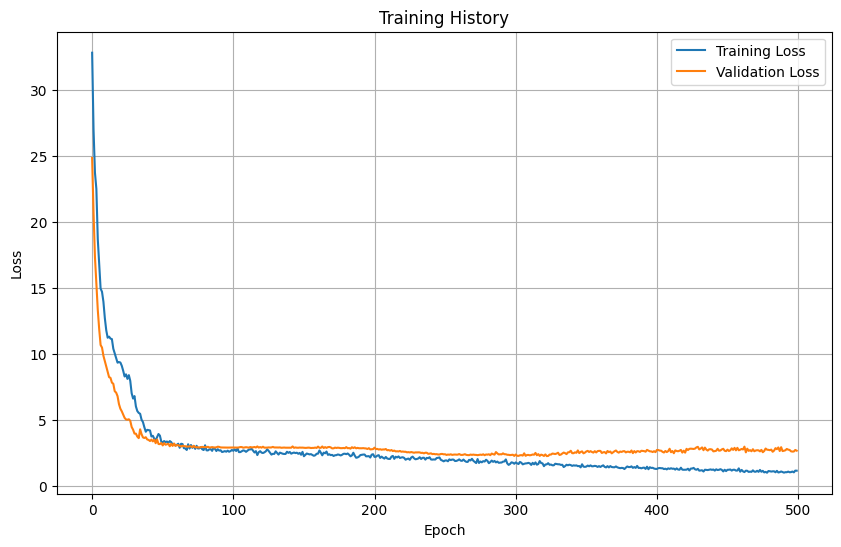

In [8]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Create dataloaders with modified parameters
train_loader, val_loader, test_loader, feature_dims = create_dataloaders(
    batch_size=64,
    use_mixup=True,
    mixup_alpha=0.4,
    use_stratified=True
)
# Create model and move to device
model = create_model(feature_dims, device)
# Training parameters
num_epochs = 500
steps_per_epoch = len(train_loader)
total_steps = num_epochs * steps_per_epoch

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=8e-4
)

scheduler = OneCycleLR(
    optimizer,
    max_lr=2e-3, 
    total_steps=total_steps,
    pct_start=0.2,       
    div_factor=10,        
    final_div_factor=500, 
    anneal_strategy='cos'
)

class HybridLoss(nn.Module):
    def __init__(self, mse_weight=0.7, l1_weight=0.3, initial_scale=0.2, epochs_to_full=50):
        super().__init__()
        self.mse_weight = mse_weight
        self.l1_weight = l1_weight
        self.scale = initial_scale
        self.epochs_to_full = epochs_to_full
        self.current_epoch = 0
        self.mse = nn.MSELoss(reduction='none')
        self.mae = nn.L1Loss(reduction='none')
        
        
    def forward(self, pred, target):
        # Calculate both losses
        mse_loss = self.mse(pred, target)
        mae_loss = self.mae(pred, target)
        
        # Combine losses with weights
        combined_loss = (self.mse_weight * mse_loss + 
                        self.l1_weight * mae_loss)
        
        # Apply adaptive scaling
        if self.current_epoch < self.epochs_to_full:
            current_scale = self.scale + (1.0 - self.scale) * (self.current_epoch / self.epochs_to_full)
        else:
            current_scale = 1.0
            
        return (combined_loss * current_scale).mean()
    
    def step(self):
        self.current_epoch += 1

# AdaptiveLoss
criterion = HybridLoss(
    initial_scale=0.2,
    epochs_to_full=100  
)

# Training
metrics = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test=False,
    test_loader=None,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=num_epochs
)


Test Loss: 2.6222
Test RMSE: 4.1279

First 50 predictions:
 Predicted	  Actual	   Error
----------------------------------------
      3.55	    4.00	   -0.45
     -1.83	    1.00	   -2.83
      0.03	   -2.00	    2.03
      3.22	    2.00	    1.22
      1.90	   -5.00	    6.90
     -0.36	    1.00	   -1.36
     -0.04	   -2.00	    1.96
     -1.87	   -2.00	    0.13
      1.59	   -8.00	    9.59
     -2.02	   -6.00	    3.98
      3.05	    3.00	    0.05
      0.09	    1.00	   -0.91
     -0.44	   -9.00	    8.56
      1.83	    6.00	   -4.17
      3.06	   -0.00	    3.06
     -3.27	    1.00	   -4.27
      7.93	    9.00	   -1.07
      3.39	    6.00	   -2.61
      1.31	    4.00	   -2.69
     -0.12	    2.00	   -2.12
      3.16	   11.00	   -7.84
      1.14	    1.00	    0.14
      8.98	    1.00	    7.98
      3.78	    5.00	   -1.22
     -0.55	   -2.00	    1.45
     -1.14	    3.00	   -4.14
      3.22	   -3.00	    6.22
      1.14	    5.00	   -3.86
      0.18	    1.00	   -0.82
     -1.34	   -1.00	   -0.34


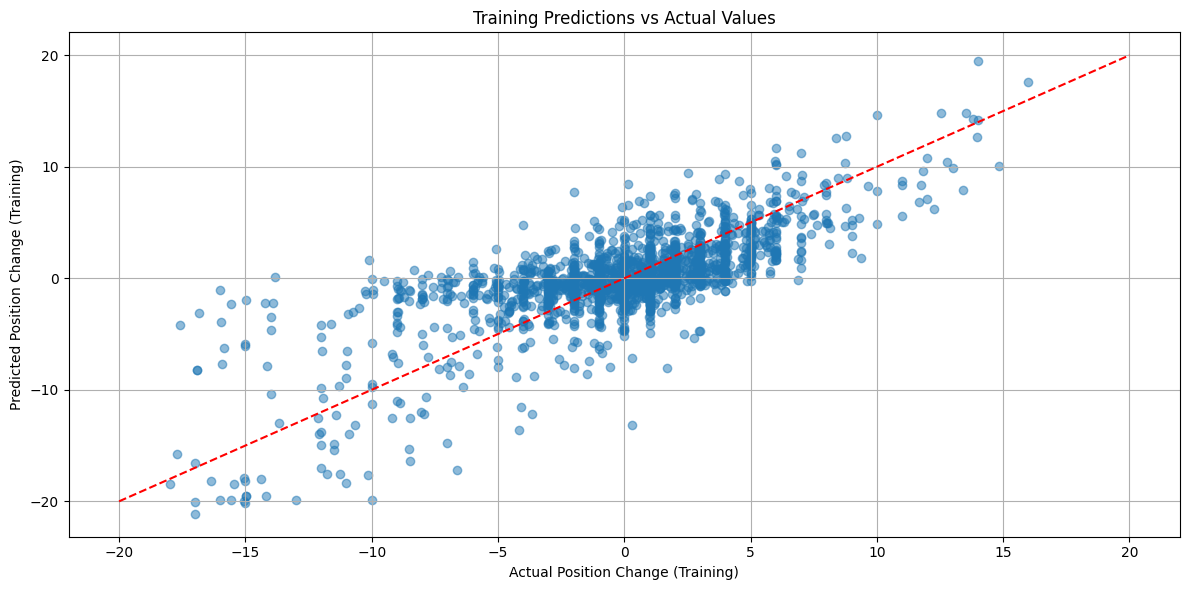

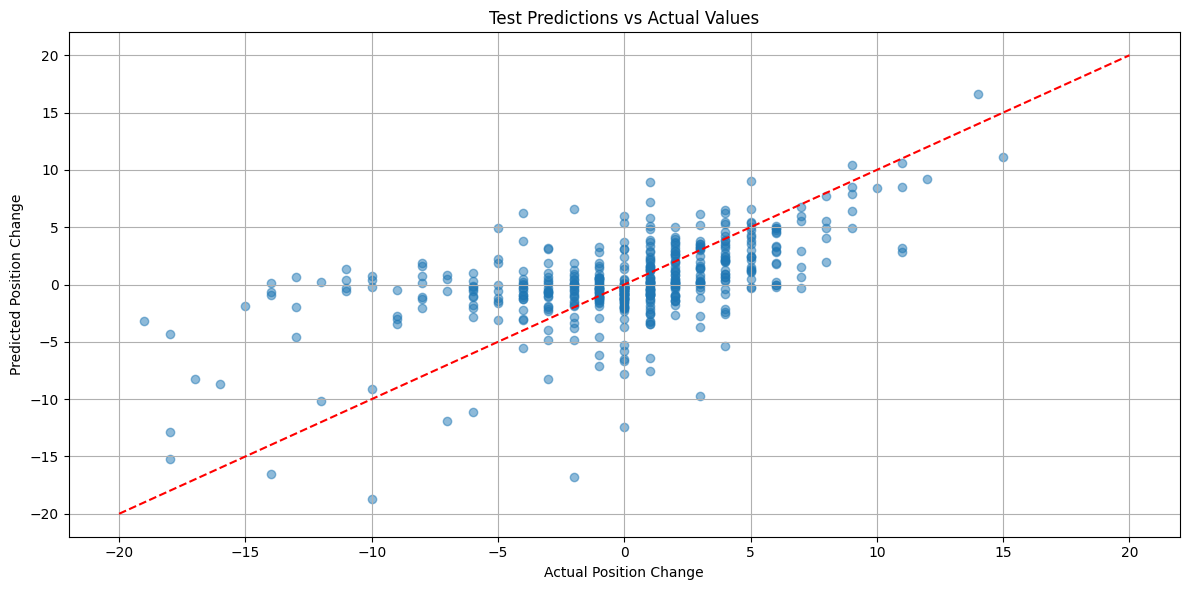

In [12]:
# Train on full train set
# Create dataloaders with modified parameters
train_val_dataset = ConcatDataset([train_loader.dataset, val_loader.dataset])

# Create a new DataLoader for the concatenated dataset
train_val_loader = torch.utils.data.DataLoader(
    train_val_dataset, batch_size=64, shuffle=True
)
# Create model and move to device
model = create_model(feature_dims, device)
num_epochs = metrics['best_epoch']
num_epochs = 270
steps_per_epoch = len(train_val_dataset)
total_steps = num_epochs * steps_per_epoch

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=8e-4
)

scheduler = OneCycleLR(
    optimizer,
    max_lr=2e-3, 
    total_steps=total_steps,
    pct_start=0.2,       
    div_factor=10,        
    final_div_factor=500, 
    anneal_strategy='cos'
)

# Training
metrics = train_model(
    model=model,
    train_loader=train_val_loader,
    val_loader=None,
    test_loader=test_loader,
    test=True,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=num_epochs
)

In [10]:
def save_model(model, feature_dims, metrics, save_path='checkpoints/f1_position_model'):
    """
    Save the trained model and its configuration
    
    Args:
        model: Trained PyTorch model
        feature_dims: Dictionary containing feature dimensions
        metrics: Dictionary containing training metrics
        save_path: Base path for saving files (without extension)
    """
    # Create a dictionary with all necessary information
    save_dict = {
        'model_state_dict': model.state_dict(),
        'feature_dims': feature_dims,
        'metrics': metrics,
        'model_config': {
            'numerical_dim': feature_dims['numerical_dim'],
            'categorical_dims': feature_dims['categorical_dims'],
            'embedding_dim': feature_dims['embedding_dim'],
            'max_pitstops': feature_dims['max_pitstops'],
            'max_tyres': feature_dims['max_tyres'],
            'num_tyre_classes': feature_dims['num_tyre_classes']
        }
    }
    
    # Save everything to a single file
    torch.save(save_dict, f'{save_path}.pth')
    print(f"\nModel saved to {save_path}.pth")
    
    # Print summary of saved information
    print("\nSaved model information:")
    print(f"Best test loss: {metrics['test_loss']:.4f}")
    print(f"Best epoch: {num_epochs}")

# Save the model
save_model(model, feature_dims, metrics)


Model saved to checkpoints/f1_position_model.pth

Saved model information:
Best test loss: 2.8858
Best epoch: 323


:::mermaid
%%{init: {'theme': 'base', 'themeVariables': { 'primaryColor': '#2f4050', 'primaryTextColor': '#fff' }}}%%
flowchart LR
    %% Input Processing
    subgraph inputs["Input Features"]
        direction TB
        cat[/"Categorical Features
        Season, Circuit, Team
        Driver, NumPitStops"/]
        num[/"Numerical
        Features"/]
        pit[/"Pitstop
        Sequence"/]
        tyre[/"Tyre
        Sequence"/]
    end

    %% Feature Processing
    subgraph proc["Feature Processing"]
        direction TB
        emb["Embeddings + Dropout
        Season(48), Circuit(96)
        Team(64), Driver(96)
        NumPitStops(32)"]
        bn["BatchNorm1d"]
        
        subgraph seq["Sequential Processing"]
            direction TB
            subgraph pit_proc["Pitstop Processing"]
                pit_lstm["BiLSTM
                1→64×2 dim
                2 layers + dropout"]
                pit_att["MultiheadAttention
                4 heads"]
            end
            
            subgraph tyre_proc["Tyre Processing"]
                tyre_emb["Tyre Embedding
                48d + dropout"]
                tyre_lstm["BiLSTM
                48→64×2 dim
                2 layers + dropout"]
                tyre_att["MultiheadAttention
                4 heads"]
            end
        end
    end

    %% Connections to processing
    cat --> emb
    num --> bn
    pit --> pit_lstm --> pit_att
    tyre --> tyre_emb --> tyre_lstm --> tyre_att

    %% Dense processing with residual
    concat1["Concatenate
    336d + num_dim"]
    dense1["Dense 512 + ReLU
    LayerNorm + Dropout"]
    dense2["Dense 512 + ReLU
    LayerNorm + Dropout"]
    dense3["Dense 512 + ReLU
    LayerNorm + Dropout"]
    
    emb & bn --> concat1
    concat1 --> dense1 --> dense2 --> dense3
    
    %% Residual connections
    concat1 -.-> dense2
    dense1 -.-> dense3

    %% Final layers
    concat2["Concatenate
    512 + 128 + 128"]
    final1["Dense 512 + ReLU
    LayerNorm + Dropout"]
    final2["Dense 256 + ReLU
    LayerNorm + Dropout"]
    final3["Dense 128 + ReLU
    LayerNorm"]
    out["Dense 1"]

    dense3 & pit_att & tyre_att --> concat2
    concat2 --> final1 --> final2 --> final3 --> out

    %% Styling
    classDef default fill:#2f4050,stroke:#fff,color:#fff,stroke-width:2px
    classDef input fill:#34495e,stroke:#fff,color:#fff
    classDef dense fill:#2c3e50,stroke:#fff,color:#fff
    classDef seq fill:#283747,stroke:#fff,color:#fff
    class concat1,concat2,dense1,dense2,dense3,final1,final2,final3 dense
    class cat,num,pit,tyre input
    class pit_lstm,tyre_lstm,pit_att,tyre_att,tyre_emb seq

| Component              | Parameter                            | Value                                       |
|------------------------|--------------------------------------|---------------------------------------------|
| **Input Features**     | Categorical Features                | Season, Circuit, Team, Driver, NumPitStops |
|                        | Numerical Features                  | Standard numerical inputs                  |
|                        | Pitstop Sequence                    | Time-series pit stop data                  |
|                        | Tyre Sequence                       | Time-series tyre data                      |
| **Feature Processing** | Embeddings + Dropout                | For categorical features                   |
|                        | BatchNorm1D                         | For numerical features                     |
| **Pitstop Processing** | BiLSTM Layers                       | 2                                         |
|                        | BiLSTM Dimensions                   | 1 → 442                                    |
|                        | BiLSTM Dropout                      | Enabled                                   |
|                        | Multihead Attention Heads           | 4                                         |
| **Tyre Processing**    | Tyre Embedding                      | 48d + dropout                              |
|                        | BiLSTM Layers                       | 2                                         |
|                        | BiLSTM Dimensions                   | 48 → 442                                   |
|                        | BiLSTM Dropout                      | Enabled                                   |
|                        | Multihead Attention Heads           | 4                                         |
| **Dense Layers**       | Concatenation                       | 336d + num_dim                            |
|                        | Fully Connected Layers              | 512 → 512 → 512                           |
|                        | Activation Function                 | ReLU                                      |
|                        | Layer Normalization                 | Enabled                                   |
|                        | Dropout                              | Enabled                                   |
| **Final Processing**   | Concatenation                       | 512 + 128 + 128                           |
|                        | Fully Connected Layers              | 512 → 256 → 128 → 128                     |
|                        | Activation Function                 | ReLU                                      |
|                        | Layer Normalization                 | Enabled                                   |
|                        | Dropout                              | Enabled                                   |
| **Output Layer**       | Final Dense Layer                   | 128 → 1                                   |

## Training Configuration

| Component | Parameter | Value |
|-----------|-----------|--------|
| Basic Setup | Batch Size | 64 |
|  | Epochs | 285 |
|  | L2 Lambda | 0.0005 |
| Optimizer | Type | AdamW |
|  | Initial LR | 8e-4 |
| Scheduler | Type | OneCycleLR |
|  | Max LR | 2e-3 |
|  | Warmup | 20% |
|  | Initial Div Factor | 10 |
|  | Final Div Factor | 500 |
|  | Annealing | Cosine |
| Data Augmentation | Mixup Alpha | 0.4 |
|  | Stratified Sampling | Enabled |
| Loss Function | Type | Hybrid (MSE: 0.7, L1: 0.3) |
|  | Initial Scale | 0.2 |
|  | Epoch to FUll Scale | 100 |